# Try plotting the val loss and train loss curve

In [37]:
# Loading modules
import pandas as pd
import numpy as np
from chemprop import data, nn, models, featurizers
from chemprop.utils.v1_to_v2 import convert_state_dict_v1_to_v2
from rdkit.Chem.inchi import MolFromInchi
from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
import torch

# Import Data

In [38]:
csv_data_file = "/home/user/YixiTFG/TFG_Yixi/SMRT_trials/SMRT_Data/SMRT_dataset.csv"
RT_data = pd.read_csv(csv_data_file, sep = ";").sample (200)
rts = RT_data.loc[:,["rt"]].values
inchis = RT_data.loc[:,"inchi"].values


# Get DataLoaders

In [39]:
# 3. Convert InChi to RDkit mol object.

mols = [ MolFromInchi(inchi, sanitize=False) for inchi in inchis ]

# 4. Preprocessing data for training

all_data = [data.MoleculeDatapoint (mol, rt) for mol, rt in zip(mols, rts)] #DataPoints

mols_cp = [ d.mol for d in all_data ] # Mol object

# Splitting

train_indices, val_indices, test_indices = data.make_split_indices(mols_cp, "random", (0.8, 0.1, 0.1))

train_data, val_data, test_data = data.split_data_by_indices(
    all_data, train_indices, val_indices, test_indices
)

# DataSets

featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_dset = data.MoleculeDataset (train_data [0], featurizer)
scaler = train_dset.normalize_targets()

val_dset = data.MoleculeDataset(val_data [0], featurizer)
val_dset.normalize_targets(scaler) #Scaling the targets.

test_dset = data.MoleculeDataset(test_data [0], featurizer)

# DataLoaders

train_loader = data.build_dataloader(train_dset, num_workers=2)
val_loader = data.build_dataloader(val_dset, num_workers=2, shuffle=False)
test_loader = data.build_dataloader(test_dset, num_workers=2, shuffle=False)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


# Define the model

In [40]:
mp = nn.BondMessagePassing ()
agg = nn.MeanAggregation ()
output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
ffn = nn.RegressionFFN (output_transform = output_transform)
batch_norm = True
metrics = [ nn.MAE (), nn.RMSE ()]
model = models.MPNN (mp, agg, ffn, batch_norm, metrics)

# Define the Pytorch.lightning Trainer with the CSVLogger

In [41]:
path_2_log_dir = "/home/user/YixiTFG/TFG_Yixi/SMRT_trials/1.0.SMRT_GNN0/1.0.2.Plot_val_train_loss/logs"
logger = CSVLogger(
    save_dir = path_2_log_dir,
)
ck_cb = ModelCheckpoint(
    monitor = "val_loss",
    mode = "min",
)

Trainer = pl.Trainer(
    logger = logger,
    callbacks = [ck_cb],
    max_epochs = 100,
    accelerator = "auto",
    devices=1,
    enable_progress_bar = False,
)

Trainer.fit (model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Loading `train_dataloader` to estimate number of stepping batches.
/home/user/Descargas/conda_nico/envs/Yixi_tfg/lib/python3.11/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/user/Descargas/conda_nico/envs/Yixi_tfg/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:317: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ message_passing │ BondMessagePassing │  227 K │ train │     0 │
│ 1 │ agg             │ MeanAggregation    │      0 │ train │     0 │
│ 2 │ bn              │ BatchNorm1d        │    600 │ train │     0 │
│ 3 │ predictor       │ RegressionFFN      │ 90.6 K │ train │     0 │
│ 4 │ X_d_transform   │ Identity           │      0 │ train │     0 │
│ 5 │ metrics         │ ModuleList         │      0 │ train │     0 │
└───┴─────────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 318 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 318 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 25                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/user/Descargas/conda_nico/envs/Yixi_tfg/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:365: Skipping 'metrics' parameter because it is not possible to safely dump to YAML.
`Trainer.fit` stopped: `max_epochs=100` reached.


# Plot val and train loss for the model

In [42]:
loss_file = "./logs/lightning_logs/version_0/metrics.csv"
loss_data = pd.read_csv (loss_file)
clean_loss_data = loss_data.drop (columns = ["step", "train_loss_step","val/mae","val/rmse"])
clean_loss_data

,epoch,train_loss_epoch,val_loss
0,0,NaN,0.416430
1,0,0.993365,NaN
2,1,NaN,0.406736
3,1,0.676430,NaN
4,2,NaN,0.399007
...,...,...,...
201,98,NaN,0.637570
202,98,0.009187,NaN
203,99,NaN,NaN
204,99,NaN,0.673500


In [43]:
epochs = np.unique (clean_loss_data ["epoch"])
epochs

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [44]:
train_loss = clean_loss_data ["train_loss_epoch"].dropna().to_numpy()
train_loss

array([0.99336469, 0.67642981, 0.4972249 , 0.47108713, 0.41936165,
       0.37692735, 0.34444308, 0.28873569, 0.26352957, 0.26115695,
       0.18127209, 0.16648176, 0.17350462, 0.159376  , 0.13174805,
       0.14155631, 0.14271845, 0.10794155, 0.10979404, 0.09714152,
       0.08762467, 0.0736884 , 0.05832272, 0.05034089, 0.04788658,
       0.05948948, 0.04419974, 0.03936247, 0.03912019, 0.03706409,
       0.02673298, 0.03481391, 0.01864329, 0.0410473 , 0.01860653,
       0.03425885, 0.01851533, 0.01942687, 0.0172009 , 0.01819219,
       0.03366872, 0.01821242, 0.01886907, 0.02434734, 0.03356083,
       0.02355129, 0.01818659, 0.02349163, 0.03488884, 0.02257487,
       0.03257773, 0.01227964, 0.01882698, 0.01419707, 0.01197736,
       0.01454698, 0.04007613, 0.01209166, 0.01477018, 0.00855608,
       0.01933958, 0.00677267, 0.01132413, 0.01647081, 0.0211401 ,
       0.01342801, 0.01132076, 0.00771814, 0.00646869, 0.01580312,
       0.00928108, 0.01475316, 0.00864055, 0.01108118, 0.01024

In [45]:
val_loss = clean_loss_data ["val_loss"].dropna ().to_numpy()
val_loss

array([0.41642982, 0.4067362 , 0.39900714, 0.40858036, 0.39864549,
       0.39411879, 0.38978887, 0.3916586 , 0.38093936, 0.38253522,
       0.38405707, 0.37947673, 0.37826914, 0.3829861 , 0.39710352,
       0.38442445, 0.37077108, 0.3487156 , 0.35788357, 0.3811419 ,
       0.38525927, 0.39239579, 0.35778123, 0.35291091, 0.34045619,
       0.53076226, 0.47130075, 0.43499917, 0.85350782, 0.55170858,
       0.47419173, 0.48212346, 0.52893287, 0.48314515, 0.563631  ,
       0.55300182, 0.63136995, 0.81108797, 0.72964633, 0.62754565,
       0.541448  , 0.7861141 , 0.53158826, 0.64842731, 0.89633572,
       0.80385476, 0.79391491, 0.95914048, 0.91577291, 0.59219587,
       0.6108343 , 0.77672356, 0.68095666, 0.61783117, 0.76422292,
       0.89781845, 0.74498558, 0.5533914 , 0.62006092, 0.78747237,
       0.62430251, 0.56155384, 0.63356102, 0.72104734, 0.69992077,
       0.59110123, 0.60180491, 0.73569113, 0.7640177 , 0.72414249,
       0.66641074, 0.69560593, 0.75611287, 0.71435314, 0.65975

In [48]:
import matplotlib.pyplot as plt
import os
def save_plot (fig_name, dir_name):
    """
    Save matplotlib.pyplot figure in .png format
    """
    actual_dir = '.'
    path2dir = actual_dir + '/'+ dir_name
    os.makedirs (path2dir, exist_ok=True)
    image_id = path2dir + '/' + fig_name + '.png'
    print (f'The plots will be saved in {path2dir}')
    plt.savefig (image_id, format = 'png')


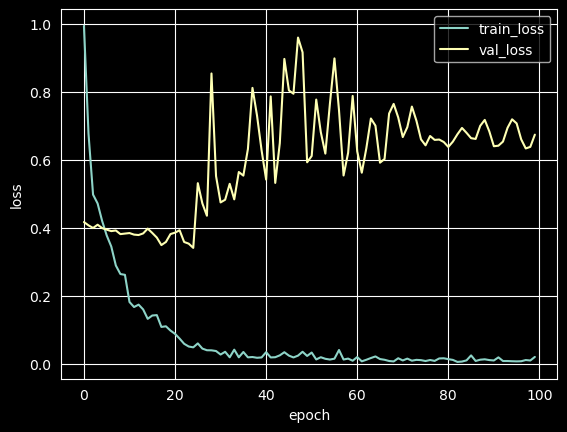

In [59]:
plt.plot (epochs, train_loss, label ="train_loss")
plt.plot (epochs, val_loss, label = "val_loss")
plt.legend ()
plt.xlabel ("epoch")
plt.ylabel ("loss")
plt.grid (True)
plt.show ()